1. Fine-tune a cross-encoder (BERT) using a small, annotated
dataset (gold dataset).
2. Create new sentence pairs.
3. Label new sentence pairs with the fine-tuned cross-encoder
(silver dataset).
4. Train a bi-encoder (SBERT) on the extended dataset (gold +
silver dataset).

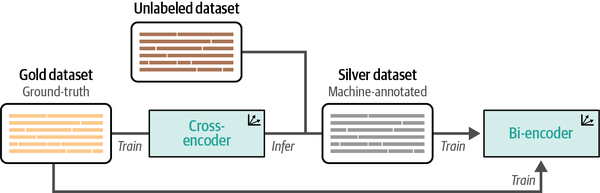

# installations

In [1]:
! pip install -U sentence_transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
from sentence_transformers import SentenceTransformer,losses,CrossEncoder
from datasets import Dataset,load_dataset
from sentence_transformers.trainer import SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import InputExample
from sentence_transformers.datasets import NoDuplicatesDataLoader

In [35]:
import pandas as pd
from tqdm import tqdm
import numpy as np

In [7]:
# load dataset
train_ds=load_dataset("glue","mnli",split="train").select(range(10000)).remove_columns("idx")
train_ds

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 10000
})

In [8]:
train_ds.to_pandas().head()

,premise,hypothesis,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0
3,How do you know? All this is their information...,This information belongs to them.,0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1


In [11]:
train_ds.to_pandas().label.unique()

array([1, 0, 2])

In [12]:
mapping={0:1,1:0,2:0}

In [15]:
gold_examples=[
    InputExample(texts=[row["premise"],row["hypothesis"]],label=mapping[row["label"]]) for row in tqdm(train_ds)
]
gold_examples[0]


100%|██████████| 10000/10000 [00:00<00:00, 15493.78it/s]


In [16]:
gold_examples[0].texts

['Conceptually cream skimming has two basic dimensions - product and geography.',
 'Product and geography are what make cream skimming work. ']

In [22]:
# create dataloader
gold_dataloader=NoDuplicatesDataLoader(gold_examples,batch_size=32)

In [23]:
gold=pd.DataFrame({
    "sentence_1":train_ds["premise"],
    "sentence_2":train_ds["hypothesis"],
    "label":[mapping[label] for label in train_ds["label"]]
})
gold.head()

,sentence_1,sentence_2,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,0
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,1
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,1
3,How do you know? All this is their information...,This information belongs to them.,1
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,0


# Train Cross Encoder

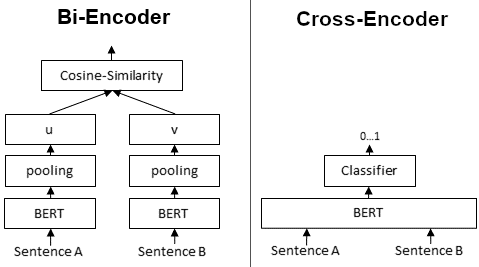

In [26]:
model_name="bert-base-uncased"
cross_encoder=CrossEncoder(model_name,num_labels=2,device="cuda")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
# test
cross_encoder.predict(("hello","hi"))

array([0.8229588, 0.1317133], dtype=float32)

In [28]:
print(cross_encoder.tokenizer.convert_ids_to_tokens(cross_encoder.tokenizer.encode(["hello","hi"])))
print(cross_encoder.tokenizer.encode(["hello","hi"]))


['[CLS]', 'hello', '[SEP]', 'hi', '[SEP]']
[101, 7592, 102, 7632, 102]


In [29]:
# train cross encoder
cross_encoder.fit(
    train_dataloader=gold_dataloader,
    epochs=1,
    show_progress_bar=True,
    warmup_steps=100
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/312 [00:00<?, ?it/s]

In [30]:
cross_encoder.predict(("hello","hi"))

array([0.27122656, 0.6284875 ], dtype=float32)

# generate silver data labels with cross encoder


In [31]:
silver=load_dataset(
    "glue","mnli",split="train"
).select(range(10_000,50_000))

In [32]:
pairs=list(zip(silver["premise"],silver["hypothesis"]))
pairs[0]

('Hindus and Buddhists still bathe where he bathed.',
 'Hindus and Buddhists bathe in the same location.')

In [33]:
output=cross_encoder.predict(pairs,apply_softmax=True,show_progress_bar=True)

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

In [34]:
output

array([[0.38977483, 0.6102252 ],
       [0.90978986, 0.09021013],
       [0.9204062 , 0.07959384],
       ...,
       [0.9238936 , 0.07610638],
       [0.39032397, 0.609676  ],
       [0.2275136 , 0.77248645]], dtype=float32)

In [36]:
np.argmax(output,axis=1)

array([1, 0, 0, ..., 0, 1, 1])

In [44]:
silver=silver.to_pandas().rename(columns={"premise":"sentence_1","hypothesis":"sentence_2"})
silver

,sentence_1,sentence_2,label,idx
0,Hindus and Buddhists still bathe where he bathed.,Hindus and Buddhists bathe in the same location.,0,10000
1,"Probably no one will even notice you at all.""",Everyone will know who you are.,2,10001
2,well what what do you mean if they can prove i...,You don't need to say anymore about the matter...,2,10002
3,I feel dizzy.,The dizziness I feel is from drinking.,1,10003
4,"Well, he did, sir.","Sir, well, he did complete it before he left l...",1,10004


In [49]:
silver["label"]=np.argmax(output,axis=1)
silver=silver.drop("idx",axis=1)

In [50]:
silver.head()

,sentence_1,sentence_2,label
0,Hindus and Buddhists still bathe where he bathed.,Hindus and Buddhists bathe in the same location.,1
1,"Probably no one will even notice you at all.""",Everyone will know who you are.,0
2,well what what do you mean if they can prove i...,You don't need to say anymore about the matter...,0
3,I feel dizzy.,The dizziness I feel is from drinking.,0
4,"Well, he did, sir.","Sir, well, he did complete it before he left l...",0


# concatenate silver and gold to ft bi-encoder

In [53]:
data=pd.concat([gold,silver],axis=0,ignore_index=True)
data

,sentence_1,sentence_2,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,0
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,1
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,1
3,How do you know? All this is their information...,This information belongs to them.,1
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,0
...,...,...,...
49995,"It was a cop, a woman of intermediate age.",The police were after us.,0
49996,"In Trinidad, Motel Las Cuevas has a disco with...",There is a disco in Motel Las Cuevas.,1
49997,Tommy's heart sank at the sight of them.,The sight of them cheered Tommy up.,0
49998,"Wodehouse, Paul Gigot and Mary McGrory.",Paul Gigot and others.,1


In [57]:
train_dataset=data.drop_duplicates(subset=["sentence_1","sentence_2"],keep="first")
train_dataset

,sentence_1,sentence_2,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,0
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,1
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,1
3,How do you know? All this is their information...,This information belongs to them.,1
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,0
...,...,...,...
49995,"It was a cop, a woman of intermediate age.",The police were after us.,0
49996,"In Trinidad, Motel Las Cuevas has a disco with...",There is a disco in Motel Las Cuevas.,1
49997,Tommy's heart sank at the sight of them.,The sight of them cheered Tommy up.,0
49998,"Wodehouse, Paul Gigot and Mary McGrory.",Paul Gigot and others.,1


In [59]:
train_dataset=Dataset.from_pandas(train_dataset,preserve_index=False)

In [60]:
train_dataset

Dataset({
    features: ['sentence_1', 'sentence_2', 'label'],
    num_rows: 49998
})

# ft

In [61]:
val_ds=load_dataset("glue","stsb",split="validation")

train-00000-of-00001.parquet:   0%|          | 0.00/502k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/114k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [65]:
evaluator=EmbeddingSimilarityEvaluator(
    sentences1=val_ds["sentence1"],
    sentences2=val_ds["sentence2"],
    scores=[label/5 for label in val_ds["label"]],
    main_similarity="cosine"
)

In [67]:
# load model
model=SentenceTransformer(model_name,device="cuda")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [68]:
# loss function
loss=losses.CosineSimilarityLoss(model=model)

In [71]:
# training args
args=SentenceTransformerTrainingArguments(
    "augment_sbert",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100
)

In [72]:
# crete trainer
trainer=SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    loss=loss,
    evaluator=evaluator
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  0%|          | 0/10000 [1:29:14<?, ?it/s]


In [73]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
100,0.219100
200,0.159300
300,0.143500
400,0.140500
500,0.139800
600,0.136500
700,0.135100
800,0.132700
900,0.134200
1000,0.132900


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=1563, training_loss=0.1407114570139313, metrics={'train_runtime': 444.4361, 'train_samples_per_second': 112.498, 'train_steps_per_second': 3.517, 'total_flos': 0.0, 'train_loss': 0.1407114570139313, 'epoch': 1.0})

In [74]:
evaluator(model)

{'pearson_cosine': 0.6926483223355764,
 'spearman_cosine': 0.7005387877197569,
 'pearson_manhattan': 0.7145845140530842,
 'spearman_manhattan': 0.7118032723618254,
 'pearson_euclidean': 0.7147169576768063,
 'spearman_euclidean': 0.712147890037372,
 'pearson_dot': 0.6549917589971139,
 'spearman_dot': 0.6544761384937086,
 'pearson_max': 0.7147169576768063,
 'spearman_max': 0.712147890037372}